# Davis-Panas-Zariphopoulou model

This notebook presents a model for pricing options in a market with proportional transaction costs. The model is taken from the celebrated work of Davis-Panas-Zariphopoulou 1993 [*link-to-the-paper*](https://web.ma.utexas.edu/users/zariphop/pdfs/TZ-7.pdf). 

#### This is a very powerful model!

However, due to its complexity, it is not very well known to the practitioners.

The purpose of this notebook is to explain **in simple terms** the main ideas of the model, and show how to implement it numerically. **The results will surprise you!**

## Contents
   - [Model description](#sec1)
      - [Portfolio dynamics (original)](#sec1.1)
      - [Some definitions](#sec1.2)
   - [Control problem](#sec2)
      - [Maximization problem](#sec2.1)
      - [Indifference pricing](#sec2.2)
   - [Variable reduction](#sec3)
      - [Minimization problem](#sec3.1)
      - [Portfolio dynamics (2 state variables)](#sec3.2)
      - [HJB variational inequality](#sec3.3)
      - [Indifference price (explicit form)](#sec3.4)
   - [Numerical Solution](#sec4)
       - [Discrete SDE](#sec4.1)
       - [Algorithm](#sec4.2)
   - [Numerical Computations](#sec5)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<a id='sec1'></a>
# Model Description

<a id='sec1.1'></a>
### Portfolio dynamics (original)
Let us consider a portfolio composed by: 
- A bank account $\mathbf{B}$ paying an interest rate $r > 0$. 
- A stock $\mathbf{S}$. 
- A number of shares $\mathbf{Y}$ of the stock $\mathbf{S}$. 

The 3-D state of the portfolio at time $t\in [t_0,T]$ is $(B_t,Y_t,S_t)$ and evolves following the SDE:

\begin{equation}
 \begin{cases}
 dB_t &=  rB_t dt - (1+\theta_b)S_{t} dL_t + (1-\theta_s) S_{t} dM_t \\
 dY_t &=  dL_t - dM_t \\
 dS_t &=  S_{t} \left( \mu dt + \sigma dW_t \right).
\end{cases}
\end{equation} 

The parameters $\theta_b$, $\theta_s \geq 0$ are the proportional transaction costs when buying and selling respectively. 

The processes  $\{(L_t, M_t)\}_{t \in [t_0,T]}$ are the **trading strategies**, i.e. the **controls** of the problem. 

The process $\{L_t\}_{t}$ represents the cumulative number of shares bought up to time $t$, and $\{M_t\}_{t}$ represents the number of shares sold up to time $t$. 
They are right-continuous, finite variation, non-negative and increasing processes. If the time $t$ is a discontinuous point (there is a transaction), the variation of the processes are indicated as
$$ \Delta L_t= L(t)-L(t^-) \quad \quad \Delta M_t= M(t)-M(t^-) $$

Let us consider an example. If at time $t$, the investor wants to buy $\Delta L_t$ shares. Then the portfolio changes as

$$ \Delta Y_t =  \underbrace{\Delta L_t}_{\mbox{shares bought}} \quad \quad
 \Delta B_t =  - \underbrace{(1+\theta_b)S_t}_{\mbox{adjusted price}} \Delta L_t $$

where the **adjusted price** is the real cost of the stock (incorporating the transaction cost).

If there are no transactions, the portfolio has the simple well known evolution:
\begin{equation}
 \begin{cases}
 dB_t &=  rB_t dt \\
 dY_t &=  0 \\
 dS_t &=  S_{t} \left( \mu dt + \sigma dW_t \right).
\end{cases}
\end{equation} 


<a id='sec1.2'></a>
### Some definitions

1. The **cash value** function $c(y,s) : \mathbb{R} \times \mathbb{R}^+ \to \mathbb{R}$, is defined as the value in cash when the shares in the portfolio are liquidated i.e.  
long positions are sold and short positions are covered.
\begin{equation}
c(y,s) := \begin{cases} 
(1+\theta_b)ys, & \mbox{if } y\leq 0 \\ 
(1-\theta_s)ys, & \mbox{if } y>0 . 
\end{cases} 
\end{equation}


2. For $t\in [t_0,T]$, the **total wealth** process in a portfolio with zero options is defined as:
\begin{equation}
 \mathcal{W}^0_t := B_t + c(Y_t,S_t).
\end{equation} 


3. If the portfolio contains an option with maturity $T$ and strike $K$, then the wealth process becomes:
 * Writer:    \begin{equation}
   \mathcal{W}^{w}_t = \; B_t + c(Y_t,S_t) \mathbb{1}_{\{t < T\}}
   + c(Y_t,S_t) \mathbb{1}_{\{t = T,\, S_t(1+ \theta_b ) \leq K\}}
   + \biggl( c\bigl( Y_t-1,S_t \bigr) + K \biggr) \mathbb{1}_{\{t=T,\, S_t(1+ \theta_b ) > K \}}
  \end{equation}
 * Buyer:     \begin{equation}
   \mathcal{W}^{b}_t = \; B_t + c(Y_t,S_t) \mathbb{1}_{\{t < T\}}
   + c(Y_t,S_t) \mathbb{1}_{\{t = T,\, S_t(1+ \theta_b ) \leq K\}}
   + \biggl( c\bigl( Y_t+1,S_t \bigr) - K \biggr) \mathbb{1}_{\{t=T,\, S_t(1+ \theta_b ) > K \}}
  \end{equation}
  
For $t_0 \leq t<T$, the wealths $\mathcal{W}^{w}_t$ and $\mathcal{W}^{b}_t$ are equal to $\mathcal{W}^{0}_t$, but when $t = T$ they differ because of the payoff of the option. The writer gives away a share and recives the strike and the buyer receive a share and pays the strike. 

Note that considering a market with transaction costs, implies a different condition for the exercise of the option. Now the buyer should exercise if $S_t(1+ \theta_b ) > K$, because the true price of the share incorporates the value of the transaction costs. Let's see the plot:

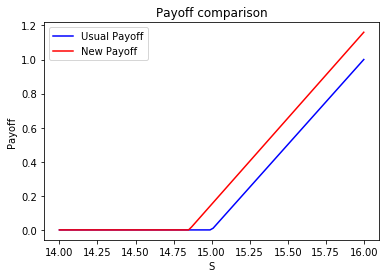

In [2]:
S = np.linspace(14,16,100)
K = 15            # strike
cost_b = 0.01        # transaction cost 

plt.plot(S, np.maximum(S-15,0), color='blue',label="Usual Payoff")
plt.plot(S, np.maximum(S*(1+cost_b)-15,0), color='red',label="New Payoff")
plt.xlabel("S")
plt.ylabel("Payoff")
plt.title("Payoff comparison")
plt.legend(loc='upper left')
plt.show()

<a id='sec2'></a>
## Control problem

<a id='sec2.1'></a>
### Maximization problem

The **value function** of the maximization problem for $j=0,w,b$ (corresponding to the three portfolios: no option, writer, buyer) is defined as:

\begin{equation}
V^j(t,b,y,s) = \sup_{L,M} \;  \mathbb{E}\biggl[ \; \mathcal{U}( \mathcal{W}^{j}_T ) \; \bigg| \; B_{t} = b, Y_{t} = y, S_{t} = s \biggr],             
\end{equation}

where $\mathcal{U}: \mathbb{R} \to \mathbb{R}$ is a concave increasing **utility function**. The **exponential utility** is what we are looking for:

\begin{equation}
 \mathcal{U}(x) := 1- e^{-\gamma x}   \quad \quad \gamma >0 .
\end{equation}

<a id='sec2.2'></a>
### Indifference pricing

The writer (buyer) option price is defined as the amount of cash to add (subtract) to the bank account, 
such that the maximal expected utility of wealth of the writer (buyer) is the same he could get with 
the zero-option portfolio.

* The **writer price** is the value $p^w>0$ such that 
 \begin{equation}
  V^0(t,b,y,s) = V^w(t,b+p^w,y,s),
 \end{equation}
 
* The **buyer price** is the value $p^b>0$ such that
 \begin{equation}
  V^0(t,b,y,s) = V^b(t,b-p^b,y,s).
 \end{equation}

<a id='sec3'></a>
## Variable reduction

Using the properties of the exponential utility, it is possible to remove $\mathbf{B}$ from the state variables.
\begin{equation}
   V^j(t,b,y,s) = \sup_{L,M} \; \mathbb{E}_{t,b,y,s}\biggl[  1- e^{-\gamma \mathcal{W}^j(T) } \biggr]   
	     = 1- e^{-\gamma \frac{b}{\delta(t,T)}} Q^j(t,y,s),
\end{equation} 
where $\delta(t,T) = e^{-r(T-t)}$. (for the full calculations, check the paper. Equations 4.21 -4.25).

<a id='sec3.1'></a>
### Minimization problem

\begin{equation}
Q^j(t,y,s) = \inf_{L,M} \; \mathbb{E}_{t,y,s}\biggl[ \;
	     e^{-\gamma \bigl[ -\int_{t}^T (1+\theta_b) \frac{S_u}{\delta(u,T)} dL_u +
	     \int_{t}^T (1-\theta_s) \frac{S_u}{\delta(u,T)} dM_u \bigr] } \; H^j(Y_T,S_T) \bigg]  
\end{equation}

The exponential term inside the expectation can be considered as a discount factor, and the second term is the terminal payoff:
 - No option:
 \begin{equation}\label{terminal_c}
  H^0(y,s) = e^{-\gamma \, c(y,s)}.
 \end{equation}
 - Writer:
  \begin{equation}\label{terminal_w}
  H^w(y,s) = e^{-\gamma \bigl[ c(y,s)\mathbb{1}_{\{s(1+\theta_b) \leq K\}} + 
 \bigl( c( y-1,s) + K \bigr) \mathbb{1}_{\{s(1+\theta_b)>K\}} \bigr] }.
 \end{equation}
 - Buyer:
  \begin{equation}\label{terminal_b}
  H^b(y,s) = e^{-\gamma \bigl[ c(y,s)\mathbb{1}_{\{s(1+\theta_b) \leq K\}} + 
 \bigl( c( y+1,s) - K \bigr) \mathbb{1}_{\{s(1+\theta_b)>K\}} \bigr] }.
 \end{equation}

<a id='sec3.2'></a>
### Portfolio dynamics (2 state variables)

In order to simplify the numerical computations,let us pass to the log-variable $X_t = \log(S_t)$.

The resulting portfolio dynamics is:

\begin{equation}
 \begin{cases}
 dY_t &=  dL_t - dM_t \\
 dX_t &= \biggl( \mu - \frac{1}{2} \sigma^2 \biggr) dt + \sigma dW_t.
\end{cases}
\end{equation} 


<a id='sec3.3'></a>
### HJB variational inequality

The Hamilton Jacobi Bellman equation associated to the minimization problem is:

\begin{equation}
 \min \; \biggl\{ \; \frac{\partial Q^j}{\partial t} + (\mu-\frac{1}{2}\sigma^2) \frac{\partial Q^j}{\partial x}
+ \frac{1}{2}\sigma^2 \frac{\partial^2 Q^j}{\partial x^2}  ,
 \; \frac{\partial Q^j}{\partial y} +(1+\theta_b) e^x \frac{\gamma}{\delta(t,T)}Q^j \; , 
\; -\biggl( \frac{\partial Q^j}{\partial y}+(1-\theta_s)e^x \frac{\gamma}{\delta(t,T)} Q^j 
\biggr) \biggr\} = 0. 
\end{equation}


<a id='sec3.4'></a>
### Indifference price (explicit form)

Using again the explicit form of the utility function, we obtain formulas for the option prices:
\begin{equation}
 p^w(t_0,y,x) = \frac{\delta(t_0,T)}{\gamma} \log \biggl( \frac{Q^w(t_0,y,e^x)}{Q^0(t_0,y,e^x)} \biggr),
\end{equation}
\begin{equation}
 p^b(t_0,y,x) = \frac{\delta(t_0,T)}{\gamma} \log \biggl( \frac{Q^0(t_0,y,e^x)}{Q^b(t_0,y,e^x)} \biggr).
\end{equation}

<a id='sec4'></a>
# Numerical Solution

<a id='sec4.1'></a>
###  Discrete SDE

As usual, we introduced the time step $\Delta t = \frac{T}{N}$, where we assumed $t_0 = 0$ and $N \in \mathbb{N}$. 
The time $t_n = n \Delta t$, for $n \in \{0,1,2, ..., N\}$. 

The space discretization has 2 dimensions:
- The space step $h_x$ is defined as $h_x = \sigma \sqrt{\Delta t}$.
- The space step is $h_y$. In this computations we choose $h_x = h_y$.

The discretized version of the Stochastic Differential equation is: 
\begin{equation}
 \begin{cases}
 \Delta Y_n &= \; \Delta L_n - \Delta M_n \\
 \Delta X_n &= \; (\mu - \frac{1}{2} \sigma^2 )  \Delta t + \sigma \Delta W_n
\end{cases}
\end{equation} 

Both $\Delta L_n$ and $\Delta M_n$ at each time $t_n$ can assume values in $\{0,h_y\}$. They cannot be different from zero at the same time (It is quite strange to buy and sell at the same time, right?)

The variable $\Delta W_n$ has $\frac{1}{2}$ probability of being equal to $h_x$ and $\frac{1}{2}$ probability of being equal to $-h_x$ 

### Binomial tree with drift

In [7]:
N = 6; dt=1/N; S0 = 15; x0 = np.log(S0) 
mu = 0.1; sig = 0.2; dx = sig * np.sqrt(dt)

for n in range(N):
    x = np.array( [x0 + (mu-0.5*sig**2)*dt*n + (2*i-n)*dx for i in range(n+1) ] )
    print(x)

[2.7080502]
[2.63973388 2.80303319]
[2.57141755 2.73471687 2.89801618]
[2.50310123 2.66640054 2.82969986 2.99299918]
[2.4347849  2.59808422 2.76138353 2.92468285 3.08798217]
[2.36646858 2.52976789 2.69306721 2.85636653 3.01966584 3.18296516]


<a id='sec4.2'></a>
###  Algorithm

Using the Dynamic Programming Principle (DPP) on the minimization problem we obtain a recursive algorithm on the nodes of the grid.

\begin{align}
 Q^{j}(t_n,Y_n,X_n) = \min  
 & \; \biggl\{ \mathbb{E}_n \biggl[ Q \bigl( t_{n+1}, Y_n, X_n + \Delta X_n \bigr) \biggr], \\ \nonumber
 & \; \exp \biggl(\frac{\gamma}{\delta(t_n,T)} (1+\theta_b) e^{X_n} \Delta L_n \biggr) 
  \mathbb{E}_n \biggl[ Q^{j} \bigl( t_{n+1}, Y_n+\Delta L_n, X_n + \Delta X_n \bigr) \biggr], \\ \nonumber
 & \; \exp \biggl(\frac{-\gamma}{\delta(t_n,T)} (1-\theta_s) e^{X_n} \Delta M_n \biggr)
  \mathbb{E}_n \biggl[ Q^{j} \bigl( t_{n+1}, Y_n-\Delta M_n, X_n + \Delta X_n \bigr) \biggr]
 \biggr\}.
\end{align}

<a id='sec5'></a>
# Numerical computations

In [4]:
from functions.Parameters import *  

opt_param = Option_param(S0=15, K=15, T=1, type_="Eu" )
diff_param = Diffusion_param(r=0.01, sig=0.2, mu=0.1)